
### T-Period Parent-Child Interaction Model with Human Capital Investment

Solves a $T$-period dynamic model where a family, consisting of a parent and a child, makes decisions over parental consumption, child's study time, education expenditure, parental labor supply, and child care time to maximize a weighted sum of their lifetime utilities. The utility function incorporates parental consumption, leisure for both parent and child, and the child's human capital, reflecting preferences over these elements and investment in the child's future human capital.

#### Model Description

The model is solved backwards from period $T$ to period 1. At each period $t = 1, \dots, T-1$, the family chooses:

- **Parental consumption** $c_{p,t} > 0$
- **Child's study time** $\tau_{c,t} \in [0, 1]$
- **Education expenditure** $e_{p,t} > 0$
- **Parental labor supply** $h_{p,t} \in [0, 1]$
- **Child care time** $\tau_{p,t} \in [0, 1]$

to maximize the value function:

- **Utility of the parent:**

$$
U_{p,t} = \phi_1 \log c_{p,t} + \phi_2 \log (1 - h_{p,t} - \tau_{p,t}) + \phi_3 \log HC_t
$$

- **Utility of the child:**

$$
U_{c,t} = \lambda_1 \log (1 - \tau_{p,t} - \tau_{c,t}) + \lambda_2 \log HC_t
$$

- **Value function:**

$$
V_t(a_t, k_t, HC_t) = \max_{c_{p,t}, \tau_{c,t}, e_{p,t}, h_{p,t}, \tau_{p,t}} \left\{ \mu \cdot U_{p,t} + (1 - \mu) \cdot U_{c,t} + \beta V_{t+1}(a_{t+1}, k_{t+1}, HC_{t+1}) \right\}
$$

subject to the following constraints:

- **Budget constraint**:
  $$
  a_{t+1} = (1 + r) a_t + w_t h_{p,t} + y - c_{p,t} - e_{p,t} \geq a_{\min}
  $$
- **Parent's human capital accumulation**:
  $$
  k_{t+1} = k_t + h_{p,t}
  $$
- **Child's human capital technology**:
  $$
  \log HC_{t+1} = \log R + \sigma_1 \log \tau_{p,t} + \sigma_2 \log e_{p,t} + \sigma_3 \log HC_t + \sigma_4 \log \tau_{c,t}
  $$
- **Wage function**:
  $$
  w_t = (1 - \text{TR}) \cdot w_0 \cdot (1 + \alpha k_t)
  $$
- **Time constraints**:

  - Parent's time:
    $$
    h_{p,t} + \tau_{p,t} \leq 0.8
    $$
  - Child's time:
    $$
    \tau_{c,t} + \tau_{p,t} \leq 0.7
    $$

**Terminal Value at Period $T$**

$$
V_T = \psi_{\text{terminal}} \cdot \log z_T
$$

Where:
- $a_t$: Assets at the beginning of period $t$
- $k_t$: Parent's human capital (cumulative labor supply)
- $HC_t$: Child's human capital level
- $w_t$: After-tax wage rate per unit of labor
- $y$: Unearned income
- $r$: Interest rate
- $\beta$: Discount factor
- $\mu$: Bargaining weight for the parent

---

### Model Parameter Settings

The following table lists the model parameters, their default values, and descriptions, as defined in the `Parent_child_interaction` constructor:

| **Parameter**   | **Value** | **Description**                                      |
|-----------------|-----------|------------------------------------------------------|
| `T`             | 8         | Number of periods                                    |
| `β` (`beta`)    | 0.97      | Discount factor                                      |
| `φ_1` (`phi_1`) | 0.3       | Parent's utility from consumption                    |
| `φ_2` (`phi_2`) | 0.3       | Parent's utility from leisure                        |
| `φ_3` (`phi_3`) | 0.4       | Parent's utility from child's human capital          |
| `R`             | 2.0       | Human capital technology scale parameter             |
| `σ_1` (`sigma_1`)| 0.2      | Elasticity of child's HC w.r.t. child care time      |
| `σ_2` (`sigma_2`)| 0.1      | Elasticity of child's HC w.r.t. education expenditure|
| `σ_3` (`sigma_3`)| 0.6      | Elasticity of child's HC w.r.t. current HC           |
| `σ_4` (`sigma_4`)| 0.1      | Elasticity of child's HC w.r.t. child's study time   |
| `λ_1` (`lambda_1`)| 0.5     | Child's utility from leisure                         |
| `λ_2` (`lambda_2`)| 0.5     | Child's utility from human capital                   |
|  `TR`    | 0.25      | Labor income tax rate                                |
| `r`             | 0.03      | Interest rate                                        |
| `y`             | 0.0       | Unearned income per period                           |
| `ψ` (`psi_terminal`)| 3.0   | Weight on terminal log human capital                 |
| `w_{0,t}`       | 12.5      | Base wage rate per period (before tax and scaling)   |
| `a_min`         | 0.0       | Minimum asset level                                  |
| `a_max`         | 10.0      | Maximum asset level (scaled by/10000)                |
| `Na`            | 30        | Number of asset grid points                          |
| `k_min`         | 0.0       | Minimum parent's human capital                       |
| `k_max`         | 10.0      | Maximum parent's human capital                       |
| `Nk`            | 30        | Number of parent's human capital grid points         |
| `HC_min`        | 1.0       | Minimum child's human capital                        |
| `HC_max`        | 10.0      | Maximum child's human capital                        |
| `Nhc`           | 30        | Number of child's human capital grid points          |
| `α` (`alpha`)   | 0.08      | Parameter in wage function                           |
| `μ` (`mu`)      | 0.6       | Bargaining weight for the parent                     |


In [2]:
using Random, NLopt, LinearAlgebra, Interpolations, Base.Threads, DataFrames
using Plots, Statistics, ProgressMeter, ForwardDiff, Distributions, Profile
using DataFrames, Measures, StatsBase, LaTeXStrings, Printf, ForwardDiff, Logging
using StaticArrays: SVector

In [42]:
# -------------------------------
# Utility: Nonlinear Grid Creator
# -------------------------------
function nonlinspace(start::Float64, stop::Float64, num::Int, curv::Float64)
    lin_vals = range(0, stop=1, length=num)
    curved_vals = lin_vals .^ curv
    return start .+ (stop - start) .* curved_vals
end

function create_focused_grid(a_min::Float64, a_focus::Float64, a_max::Float64, Na::Int, focus_share::Float64, curv::Float64)
    Na_focus = ceil(Int, Na * focus_share)
    Na_rest = Na - Na_focus
    grid_focus = nonlinspace(a_min, a_focus, Na_focus, curv)
    grid_rest = nonlinspace(a_focus, a_max, Na_rest + 1, curv)[2:end]
    return vcat(grid_focus, grid_rest)
end

# -------------------------------
# Dynamic Family Model Definition
# -------------------------------
using Random

mutable struct Parent_child_interaction
    # --- Model Parameters ---
    T::Int                        # Number of periods
    beta::Float64                 # Discount factor
    phi_1::Float64                # Parent's disutility of labor
    phi_2::Float64                # Parent's utility from human capital
    phi_3::Float64                # Parent's utility from consumption
    R::Float64                    # Human capital technology parameter
    sigma_1::Float64              # Elasticity: HC w.r.t. child care time
    sigma_2::Float64              # Elasticity: HC w.r.t. investment
    sigma_3::Float64              # Elasticity: HC w.r.t. current human capital
    sigma_4::Float64              # Elasticity: HC w.r.t. child's own study time
    lambda_1::Float64              # Child's utiltiy of labor
    lambda_2::Float64              # Child's utility from human capital
    tau::Float64                  # Labor income tax
    r::Float64                    # Interest rate
    y::Float64                    # Unearned income
    a_max::Float64                # Max asset level
    a_min::Float64                # Min asset level
    Na::Int                       # Asset grid size
    k_max::Float64                # Max physical capital
    k_min::Float64                # Min physical capital
    Nk::Int                       # Physical capital grid size
    hc_max::Float64               # Max human capital (for child/parent)
    hc_min::Float64               # Min human capital
    Nhc::Int                      # Human capital grid size
    alpha::Float64                # Parameter in wage function
    psi_terminal::Float64         # importance of terminal HC
    mu::Float64                   # Parameter for bargining inside the family

    # --- Grids ---
    a_grid::Vector{Float64}       # Asset grid
    k_grid::Vector{Float64}       # Physical capital grid
    hc_grid::Vector{Float64}      # Human capital grid

    # --- Solution Arrays (for value function iteration) ---
    sol_c::Array{Float64,4}       # Parental consumption    [T, Na, Nk, Nhc]
    sol_i::Array{Float64,4}       # Child own study time    [T, Na, Nk, Nhc]
    sol_h::Array{Float64,4}       # Parental labor supply   [T, Na, Nk, Nhc]
    sol_t::Array{Float64,4}       # Child care time         [T, Na, Nk, Nhc]
    sol_e::Array{Float64,4}       # Education expenditure   [T, Na, Nk, Nhc]
    sol_v::Array{Float64,4}       # Value function          [T, Na, Nk, Nhc]

    # --- Simulation Storage ---
    simN::Int                     # Number of simulated agents
    simT::Int                     # Number of simulation periods
    sim_c::Array{Float64,2}       # Simulated consumption   [simN, simT]
    sim_h::Array{Float64,2}       # Simulated labor         [simN, simT]
    sim_t::Array{Float64,2}       # Simulated child care    [simN, simT]
    sim_e::Array{Float64,2}       # Simulated education exp [simN, simT]
    sim_a::Array{Float64,2}       # Simulated assets        [simN, simT]
    sim_i::Array{Float64,2}       # Simulated child study   [simN, simT]
    sim_k::Array{Float64,2}       # Simulated capital       [simN, simT]
    sim_hc::Array{Float64,2}      # Simulated human capital [simN, simT]
    sim_wage::Array{Float64,2}     # Simulated wage         [simN, simT]
    sim_income::Array{Float64,2}   # Simulated income       [simN, simT]


    # --- Initial conditions ---
    sim_a_init::Vector{Float64}   # Initial assets          [simN]
    sim_k_init::Vector{Float64}   # Initial capital         [simN]
    sim_hc_init::Vector{Float64}  # Initial human capital   [simN]

    # --- Wage vector (for each period) ---
    w_vec::Vector{Float64}        # Wage per period         [T]
end

function Parent_child_interaction(; T::Int=8, beta::Float64=0.97,
                        phi_1::Float64=0.3, phi_2::Float64=0.3, phi_3::Float64=0.4,
                        R::Float64=2.0, sigma_1::Float64=0.2, sigma_2::Float64=0.1, 
                        sigma_3::Float64=0.6, sigma_4::Float64=0.1,
                        lambda_1::Float64=0.5, lambda_2::Float64=0.5,
                        tau::Float64=0.25, r::Float64=0.03,
                        y::Float64=0.0, a_max::Float64=10.0,
                        a_min::Float64=0.0, Na::Int=30, psi_terminal::Float64=3.0,
                        k_max::Float64=10.0, k_min::Float64=0.0, Nk::Int=30,
                        hc_max::Float64=10.0, hc_min::Float64=1.0, Nhc::Int=30,
                        simN::Int=5000, simT::Int=T, alpha::Float64=0.08, seed::Int=1234,
                        mu::Float64=0.6)  # Bargaining parameter


    # Grids (custom grid functions)
    a_grid = create_focused_grid(a_min, 5.0, a_max, Na, 0.8, 1.2)
    #a_grid = nonlinspace(a_min, a_max, Na, 1.2)
    #k_grid = nonlinspace(k_min, k_max, Nk, 1.2)
    k_grid = create_focused_grid(k_min, 3.0, k_max, Nk, 0.7, 1.2)
    hc_grid = create_focused_grid(hc_min, 2.0, hc_max, Nhc, 0.7, 1.2)

    # Solution arrays (4D: [T, Na, Nk, Nhc])
    sol_shape = (T, Na, Nk, Nhc)
    sol_c = fill(NaN, sol_shape)
    sol_i = fill(NaN, sol_shape)
    sol_h = fill(NaN, sol_shape)
    sol_t = fill(NaN, sol_shape)
    sol_e = fill(NaN, sol_shape)
    sol_v = fill(NaN, sol_shape)

    # Simulation arrays (2D: [simN, simT])
    sim_shape = (simN, simT)
    sim_c = fill(NaN, sim_shape)
    sim_h = fill(NaN, sim_shape)
    sim_t = fill(NaN, sim_shape)
    sim_e = fill(NaN, sim_shape)
    sim_i = fill(NaN, sim_shape)  
    sim_a = fill(NaN, sim_shape)
    sim_k = fill(NaN, sim_shape)
    sim_hc = fill(NaN, sim_shape)
    sim_wage = fill(NaN, sim_shape)
    sim_income = fill(NaN, sim_shape)

    # Initial conditions
    sim_a_init = zeros(Float64, simN)
    sim_k_init = fill(k_min, simN)
    sim_hc_init = fill(hc_min, simN)

    # Wage vector
    w_vec = fill(12.5, T)

    return Parent_child_interaction(T, beta, phi_1, phi_2, phi_3, R, sigma_1, sigma_2, sigma_3, sigma_4,
                                    lambda_1, lambda_2, 
                                    tau, r, y, a_max, a_min, Na, k_max, k_min, Nk, hc_max, hc_min, Nhc, alpha, psi_terminal, mu,
                                    a_grid, k_grid, hc_grid,
                                    sol_c, sol_i, sol_h, sol_t, sol_e, sol_v,
                                    simN, simT, sim_c, sim_h, sim_t, sim_e, sim_i, sim_a, sim_k, sim_hc, sim_wage, sim_income,
                                    sim_a_init, sim_k_init, sim_hc_init,
                                    w_vec)
end

Parent_child_interaction

In [39]:

function solve_model!(model::Parent_child_interaction)
    T, Na, Nk, Nhc = model.T, model.Na, model.Nk, model.Nhc
    a_grid, k_grid, hc_grid = model.a_grid, model.k_grid, model.hc_grid

    # Last period (t = T)
    Threads.@threads for i_a in 1:Na
        for i_k in 1:Nk
            for i_hc in 1:Nhc
                assets = a_grid[i_a]
                capital = k_grid[i_k]
                HC = hc_grid[i_hc]

                function obj_wrapper(x::Vector, grad::Vector)
                    e_p, i_c, h_p, t_p = x[1], x[2], x[3], x[4]
                    f = obj_last_period(model, e_p, i_c, h_p, t_p, assets, HC, capital, T, grad)
                    if length(grad) > 0
                        grad[:] = -grad[:]  # NLopt minimizes, so negate gradient
                    end
                    return -f
                end

                opt = Opt(:LD_SLSQP, 4)
                lower_bounds!(opt, [1e-4, 1e-4, 0.0, 1e-4])
                upper_bounds!(opt, [50, 1.0, 1.0, 1.0])
                inequality_constraint!(opt, constraint_min_leisure, 1e-4)
                inequality_constraint!(opt, constraint_child_time, 1e-4)
                min_objective!(opt, obj_wrapper)
                init = [1.0, 0.2, 0.3, 0.3]
                ftol_rel!(opt, 1e-6)
                maxeval!(opt, 10000)
                (minf, x_opt, ret) = optimize(opt, init)
                @info "Last period (t=$T, i_a=$i_a, i_k=$i_k, i_hc=$i_hc): minf=$minf, x_opt=$x_opt, ret=$ret"

                # Store solutions
                model.sol_e[T, i_a, i_k, i_hc] = x_opt[1]
                model.sol_i[T, i_a, i_k, i_hc] = x_opt[2]
                model.sol_h[T, i_a, i_k, i_hc] = x_opt[3]
                model.sol_t[T, i_a, i_k, i_hc] = x_opt[4]
                model.sol_c[T, i_a, i_k, i_hc] = assets + wage_func(model, k_grid[i_k], T) * x_opt[3] + model.y - x_opt[1]
                model.sol_v[T, i_a, i_k, i_hc] = -minf
            end
        end
    end

    # Earlier periods (t = T-1 to 1)
    for t in (T-1):-1:1
        println("Solving period $t ...")
        interp = create_interp(model, model.sol_v, t+1)
        Threads.@threads for i_a in 1:Na
            for i_k in 1:Nk
                for i_hc in 1:Nhc
                    assets = a_grid[i_a]
                    capital = k_grid[i_k]
                    HC = hc_grid[i_hc]
                    function obj_wrapper(x::Vector, grad::Vector)
                        c_p, i_c, e_p, h_p, t_p = x
                        f = obj_work_period(model, c_p, i_c, e_p, h_p, t_p, assets, HC, capital, t, interp, grad)
                        if length(grad) > 0
                            grad[:] = -grad[:]
                        end
                        return -f
                    end

                    opt = Opt(:LD_SLSQP, 5)
                    lower_bounds!(opt, [1e-4, 0.0, 0.0, 0.0, 0.0])
                    upper_bounds!(opt, [50, 1.0, 50, 1.0, 1.0])
                    inequality_constraint!(opt, constraint_min_leisure, 1e-4)
                    inequality_constraint!(opt, constraint_child_time, 1e-4)
                    inequality_constraint!(opt, (x, grad) -> asset_constraint(x, grad, model, capital, t, assets), 1e-4)
                    min_objective!(opt, obj_wrapper)
                    init = [model.sol_c[t+1, i_a, i_k, i_hc],
                            model.sol_i[t+1, i_a, i_k, i_hc],
                            model.sol_e[t+1, i_a, i_k, i_hc],
                            min(model.sol_h[t+1, i_a, i_k, i_hc], 0.5),
                            min(model.sol_t[t+1, i_a, i_k, i_hc], 0.5)]
                    ftol_rel!(opt, 1e-6)
                    maxeval!(opt, 10000)
                    (minf, x_opt, ret) = optimize(opt, init)
                    @info "Work period (t=$t, i_a=$i_a, i_k=$i_k, i_hc=$i_hc): minf=$minf, x_opt=$x_opt, ret=$ret"

                    # Store solutions
                    model.sol_c[t, i_a, i_k, i_hc] = x_opt[1]
                    model.sol_i[t, i_a, i_k, i_hc] = x_opt[2]
                    model.sol_e[t, i_a, i_k, i_hc] = x_opt[3]
                    model.sol_h[t, i_a, i_k, i_hc] = x_opt[4]
                    model.sol_t[t, i_a, i_k, i_hc] = x_opt[5]
                    model.sol_v[t, i_a, i_k, i_hc] = -minf
                end
            end
        end
    end
end

# Supporting functions remain unchanged
function obj_last_period(
    model::Parent_child_interaction, e_p::Float64, i_c::Float64, h_p::Float64, t_p::Float64,
    assets::Float64, log_HC::Float64, capital::Float64, t::Int, grad::Vector
)
    w = wage_func(model, capital, t)
    c = assets + w * h_p + model.y - e_p
    leisure_p = 1.0 - h_p - t_p
    leisure_c = 1.0 - t_p - i_c
    log_HC_next = HC_technology(model, t_p, e_p, log_HC, i_c)
    util_now = util_total(model, c, h_p, t_p, i_c, log_HC)
    terminal = terminal_value(model, log_HC_next)
    f = util_now + terminal

    if length(grad) > 0
        dlogHC_de = model.sigma_2 / e_p
        dlogHC_dt = model.sigma_1 / t_p
        grad[1] = model.mu * (model.phi_1 / c) * (-1) + model.psi_terminal * dlogHC_de
        grad[2] = (1 - model.mu) * (model.lambda_1 / leisure_c) * (-1) + model.psi_terminal * (model.sigma_4 / i_c)
        grad[3] = model.mu * (model.phi_1 / c * w + model.phi_2 / leisure_p * (-1))
        grad[4] = model.mu * (model.phi_2 / leisure_p * (-1)) + 
                  (1 - model.mu) * (model.lambda_1 / leisure_c * (-1)) + 
                  model.psi_terminal * dlogHC_dt
    end
    return f
end

function obj_work_period(
    model::Parent_child_interaction, c_p::Float64, i_c::Float64, e_p::Float64, h_p::Float64, t_p::Float64,
    assets::Float64, log_HC::Float64, capital::Float64, t::Int, interp, grad::Vector
)
    w = wage_func(model, capital, t)
    income = w * h_p
    a_next = (1.0 + model.r) * assets + income + model.y - c_p - e_p
    k_next = capital + h_p
    leisure_p = 1.0 - h_p - t_p
    leisure_c = 1.0 - t_p - i_c
    log_HC_next = HC_technology(model, t_p, e_p, log_HC, i_c)
    util_now = util_total(model, c_p, h_p, t_p, i_c, log_HC)
    V_next = interp(a_next, k_next, log_HC_next)
    f = util_now + model.beta * V_next

    if length(grad) > 0
        ∇V_next = gradient(interp, a_next, k_next, log_HC_next)
        ∂V_∂a, ∂V_∂k, ∂V_∂logHC = ∇V_next
        dlogHC_de = model.sigma_2 / e_p
        dlogHC_dt = model.sigma_1 / t_p
        # Cache common terms
        term_leisure_p = model.mu * model.phi_2 / leisure_p * (-1)
        term_leisure_c = (1 - model.mu) * model.lambda_1 / leisure_c * (-1)
        grad[1] = model.mu * model.phi_1 / c_p + model.beta * ∂V_∂a * (-1)
        grad[2] = term_leisure_c + model.beta * ∂V_∂logHC * (model.sigma_4 / i_c)
        grad[3] = model.beta * (∂V_∂a * (-1) + ∂V_∂logHC * dlogHC_de)
        grad[4] = term_leisure_p + model.beta * (∂V_∂a * w + ∂V_∂k)
        grad[5] = term_leisure_p + term_leisure_c + model.beta * ∂V_∂logHC * dlogHC_dt
    end
    return f
end

@inline function util_total(model::Parent_child_interaction, c::Float64, h_p::Float64,
                            t_p::Float64, i_c::Float64, log_HC::Float64)
    leisure_p = 1.0 - h_p - t_p
    leisure_c = 1.0 - t_p - i_c
    if leisure_p <= 0.0 || c <= 0.0 || i_c <= 0.0 || leisure_c <= 0.0
        return -Inf
    end
    u_parent = model.phi_1 * log(c) + model.phi_2 * log(leisure_p) + model.phi_3 * log_HC
    u_child  = model.lambda_1 * log(leisure_c) + model.lambda_2 * log_HC
    return model.mu * u_parent + (1 - model.mu) * u_child
end

@inline function HC_technology(model::Parent_child_interaction, t_p::Float64, e_p::Float64, log_HC::Float64, i_c::Float64)
    if t_p <= 0.0 || e_p <= 0.0 || i_c <= 0.0
        return -Inf
    end
    return log(model.R) + model.sigma_1 * log(t_p) + model.sigma_2 * log(e_p) + model.sigma_3 * log_HC + model.sigma_4 * log(i_c)
end

@inline function terminal_value(model::Parent_child_interaction, log_HC_next::Float64)
    return model.psi_terminal * log_HC_next
end

@inline function wage_func(model::Parent_child_interaction, capital::Float64, t::Int)
    return (1 - model.tau) * model.w_vec[t] * (1.0 + model.alpha * capital) * 0.584
end

function create_interp(model::Parent_child_interaction, sol_v, t)
    itp = interpolate(
        (model.a_grid, model.k_grid, model.hc_grid),
        sol_v[t, :, :, :],
        Gridded(Linear())
    )
    return extrapolate(itp, Line())
end


# Define constraints outside the loops
@inline function constraint_min_leisure(x::Vector, grad::Vector)
    n = length(x)
    h_p = x[n-1]  # Second-to-last element
    t_p = x[n]    # Last element
    if length(grad) > 0
        grad .= 0.0
        grad[n-1] = 1.0  # ∂g/∂h_p
        grad[n]   = 1.0  # ∂g/∂t_p
    end
    return (h_p + t_p) - 0.8  # h_p + t_p <= 0.8
end

@inline function constraint_child_time(x::Vector, grad::Vector)
    if length(x) == 4  # Last period: [e_p, i_c, h_p, t_p]
        i_c = x[2]
        t_p = x[4]
    elseif length(x) == 5  # Work periods: [c_p, i_c, e_p, h_p, t_p]
        i_c = x[2]
        t_p = x[5]
    end
    if length(grad) > 0
        grad .= 0.0
        if length(x) == 4
            grad[2] = 1.0  # ∂g/∂i_c
            grad[4] = 1.0  # ∂g/∂t_p
        elseif length(x) == 5
            grad[2] = 1.0  # ∂g/∂i_c
            grad[5] = 1.0  # ∂g/∂t_p
        end
    end
    return (i_c + t_p) - 0.7  # i_c + t_p <= 0.6
end

@inline function asset_constraint(x::Vector, grad::Vector, model::Parent_child_interaction, capital::Float64, t::Int, assets::Float64)
    c_p, i_c, e_p, h_p, t_p = x
    w = wage_func(model, capital, t)
    a_next = (1.0 + model.r) * assets + w * h_p + model.y - c_p - e_p
    if length(grad) > 0
        grad[1] = 1.0   # ∂g/∂c_p
        grad[2] = 0.0   # ∂g/∂i_c
        grad[3] = 1.0   # ∂g/∂e_p
        grad[4] = -w    # ∂g/∂h_p
        grad[5] = 0.0   # ∂g/∂t_p
    end
    return model.a_min - a_next  # a_next >= a_min, so g(x) ≤ 0
end

asset_constraint (generic function with 1 method)

In [26]:
using Logging, LoggingExtras

# Set up a file logger
logfile = open("optimization_log.txt", "w")
global_logger(
    TeeLogger(
        FileLogger(logfile),
        ConsoleLogger(stderr)  # or remove this line if you want *only* to file
    )
)

FileLogger(Base.CoreLogging.SimpleLogger(IOStream(<file optimization_log.txt>), BelowMinLevel, Dict{Any, Int64}()), true)

In [27]:
global_logger(FileLogger(logfile))

TeeLogger{Tuple{FileLogger, ConsoleLogger}}((FileLogger(Base.CoreLogging.SimpleLogger(IOStream(<file optimization_log.txt>), BelowMinLevel, Dict{Any, Int64}()), true), ConsoleLogger(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), Info, Base.CoreLogging.default_metafmt, true, 0, Dict{Any, Int64}())))

In [43]:
model_baseline = Parent_child_interaction()
solve_model!(model_baseline)

Solving period 7 ...
Solving period 6 ...
Solving period 5 ...
Solving period 4 ...
Solving period 3 ...
Solving period 2 ...
Solving period 1 ...


In [ ]:
close(logfile)

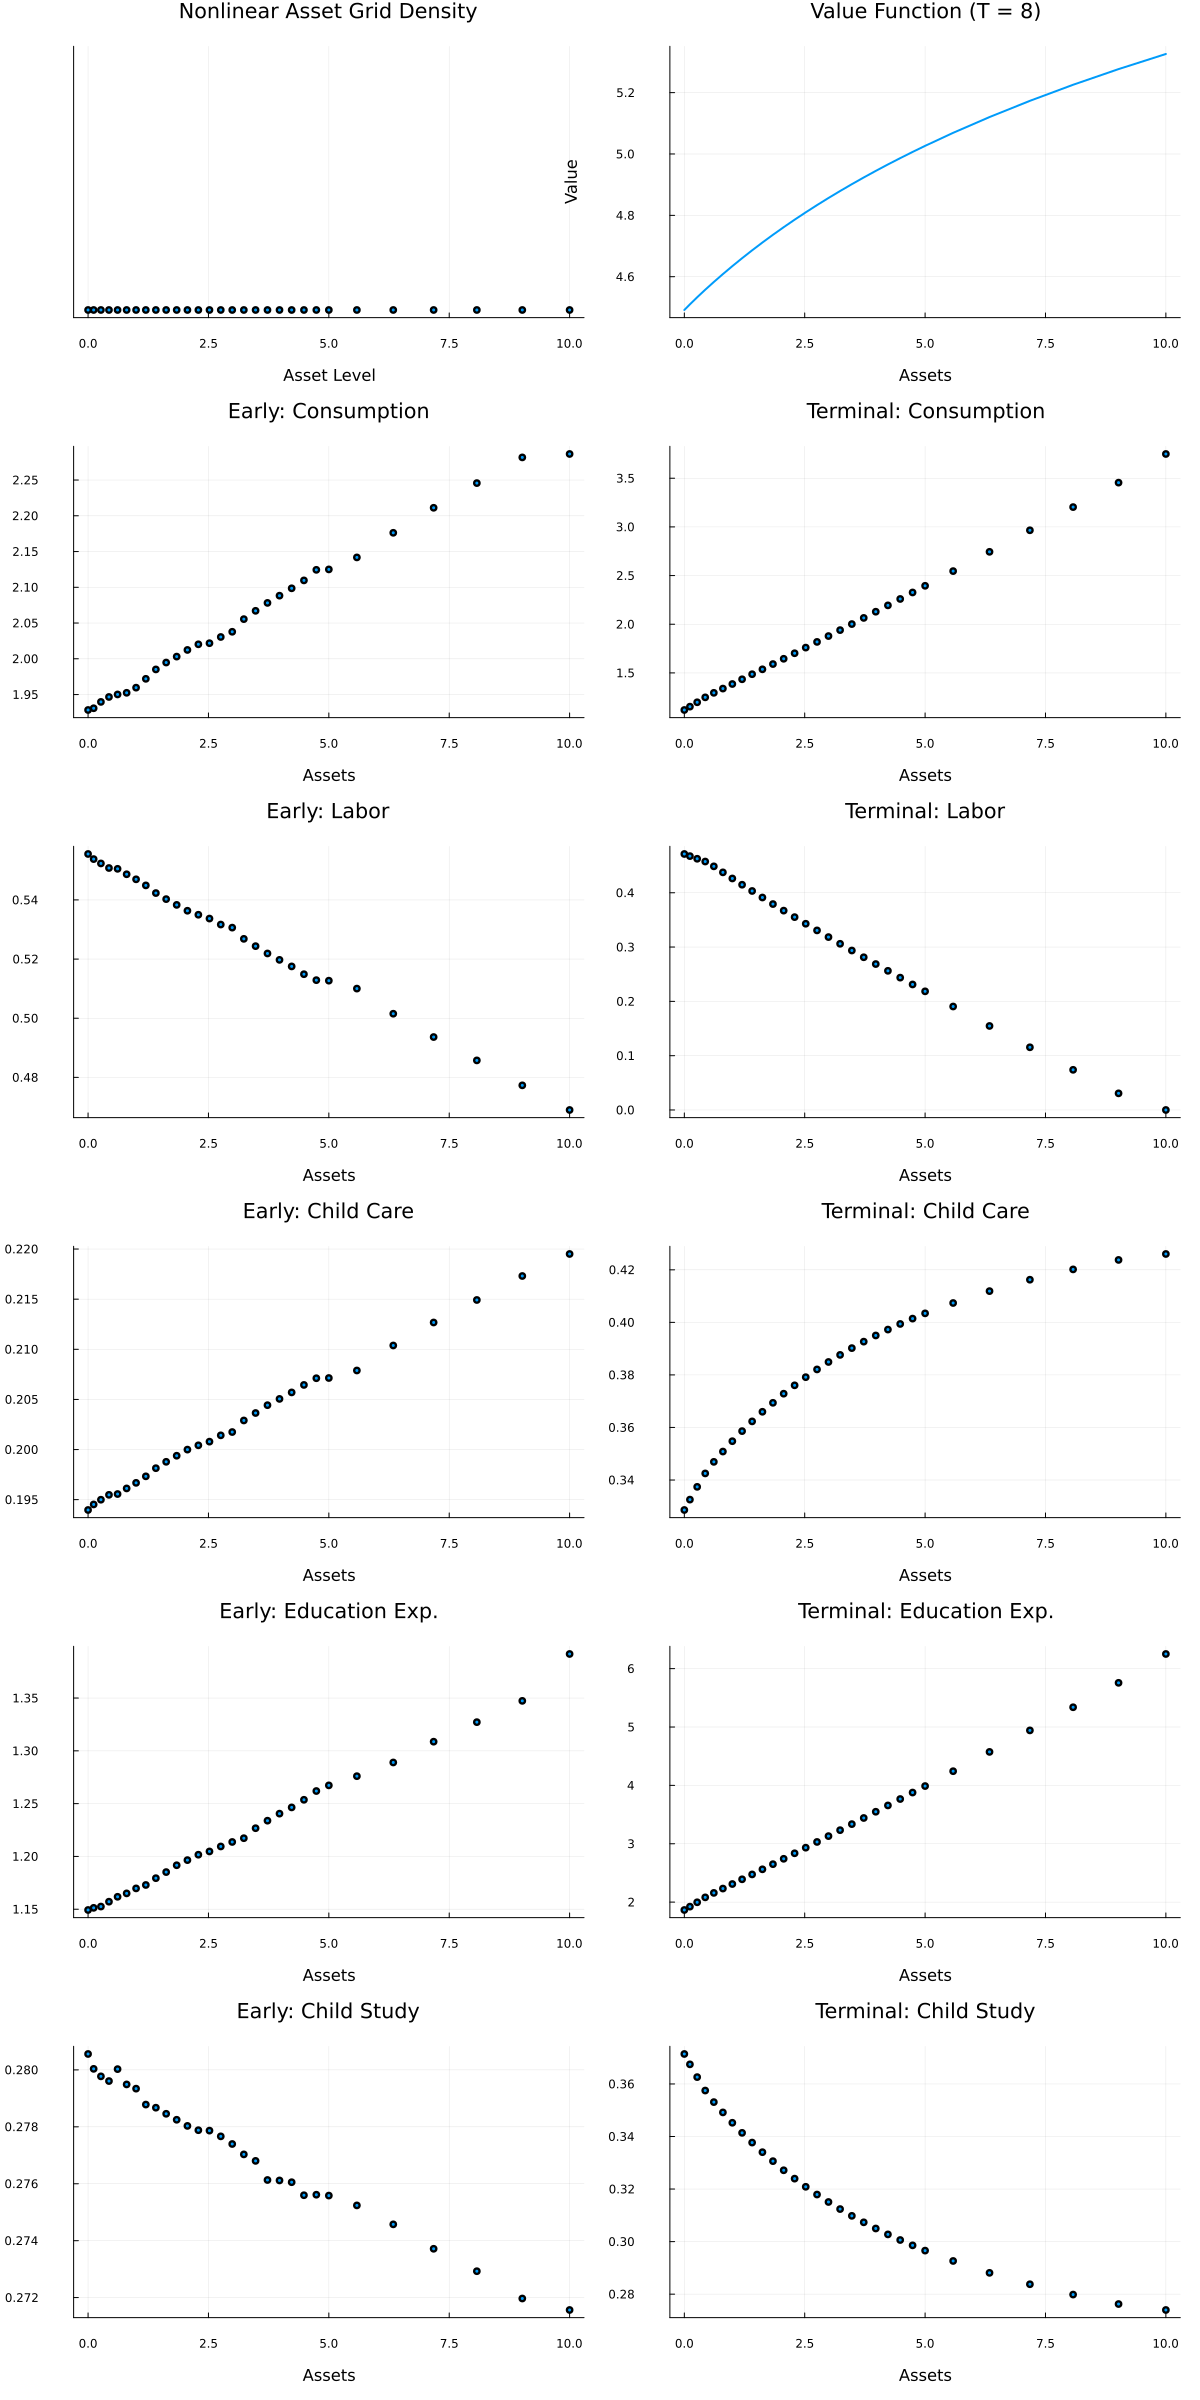

In [44]:
using Plots

# Indices
k_mid = Int(ceil(length(model_baseline.k_grid) / 2))
hc_mid = Int(ceil(length(model_baseline.hc_grid) / 2))
T_terminal = model_baseline.T
t_early = 1
a_grid = model_baseline.a_grid

# 1. Nonlinear asset grid
p1 = scatter(
    a_grid, zeros(length(a_grid));
    xlabel = "Asset Level", yticks = [],
    title = "Nonlinear Asset Grid Density",
    markersize = 3, legend = false)

p2 = plot(
    a_grid, model_baseline.sol_v[T_terminal, :, k_mid, hc_mid];
    xlabel = "Assets", ylabel = "Value",
    title = "Value Function (T = $(T_terminal))",
    label = "Vₜ(a)", linewidth = 2)

# 2. Consumption
p3 = scatter(
    a_grid, model_baseline.sol_c[t_early, :, k_mid, hc_mid];
    xlabel = "Assets", ylabel = "Consumption",
    title = "Early: Consumption", label = "cₜ(a)", markersize = 3)
p4 = scatter(
    a_grid, model_baseline.sol_c[T_terminal, :, k_mid, hc_mid];
    xlabel = "Assets", ylabel = "",
    title = "Terminal: Consumption", label = "cₜ(a)", markersize = 3)

# 3. Labor
p5 = scatter(
    a_grid, model_baseline.sol_h[t_early, :, k_mid, hc_mid];
    xlabel = "Assets", ylabel = "Labor",
    title = "Early: Labor", label = "hₜ(a)", markersize = 3)
p6 = scatter(
    a_grid, model_baseline.sol_h[T_terminal, :, k_mid, hc_mid];
    xlabel = "Assets", ylabel = "",
    title = "Terminal: Labor", label = "hₜ(a)", markersize = 3)

# 4. Child care time
p7 = scatter(
    a_grid, model_baseline.sol_t[t_early, :, k_mid, hc_mid];
    xlabel = "Assets", ylabel = "Child Care",
    title = "Early: Child Care", label = "tₜ(a)", markersize = 3)
p8 = scatter(
    a_grid, model_baseline.sol_t[T_terminal, :, k_mid, hc_mid];
    xlabel = "Assets", ylabel = "",
    title = "Terminal: Child Care", label = "tₜ(a)", markersize = 3)

# 5. Education expenditure
p9 = scatter(
    a_grid, model_baseline.sol_e[t_early, :, k_mid, hc_mid];
    xlabel = "Assets", ylabel = "Education Exp.",
    title = "Early: Education Exp.", label = "eₜ(a)", markersize = 3)
p10 = scatter(
    a_grid, model_baseline.sol_e[T_terminal, :, k_mid, hc_mid];
    xlabel = "Assets", ylabel = "",
    title = "Terminal: Education Exp.", label = "eₜ(a)", markersize = 3)

# 6. Child study time (i_c)
p11 = scatter(
    a_grid, model_baseline.sol_i[t_early, :, k_mid, hc_mid];
    xlabel = "Assets", ylabel = "Child Study",
    title = "Early: Child Study", label = "iₜ(a)", markersize = 3)
p12 = scatter(
    a_grid, model_baseline.sol_i[T_terminal, :, k_mid, hc_mid];
    xlabel = "Assets", ylabel = "",
    title = "Terminal: Child Study", label = "iₜ(a)", markersize = 3)

# Combine all plots into a 6×2 grid
plot(
    p1,  p2,
    p3,  p4,
    p5,  p6,
    p7,  p8,
    p9,  p10,
    p11, p12,
    layout = (6, 2),
    size = (1200, 2400),
    margin = 3mm,
    legend = false
)

In [35]:
using Profile

Profile.clear()   # Clear any previous data
@profile solve_model!(model_baseline)

Solving period 7 ...
Solving period 6 ...
Solving period 5 ...
Solving period 4 ...
Solving period 3 ...
Solving period 2 ...
Solving period 1 ...


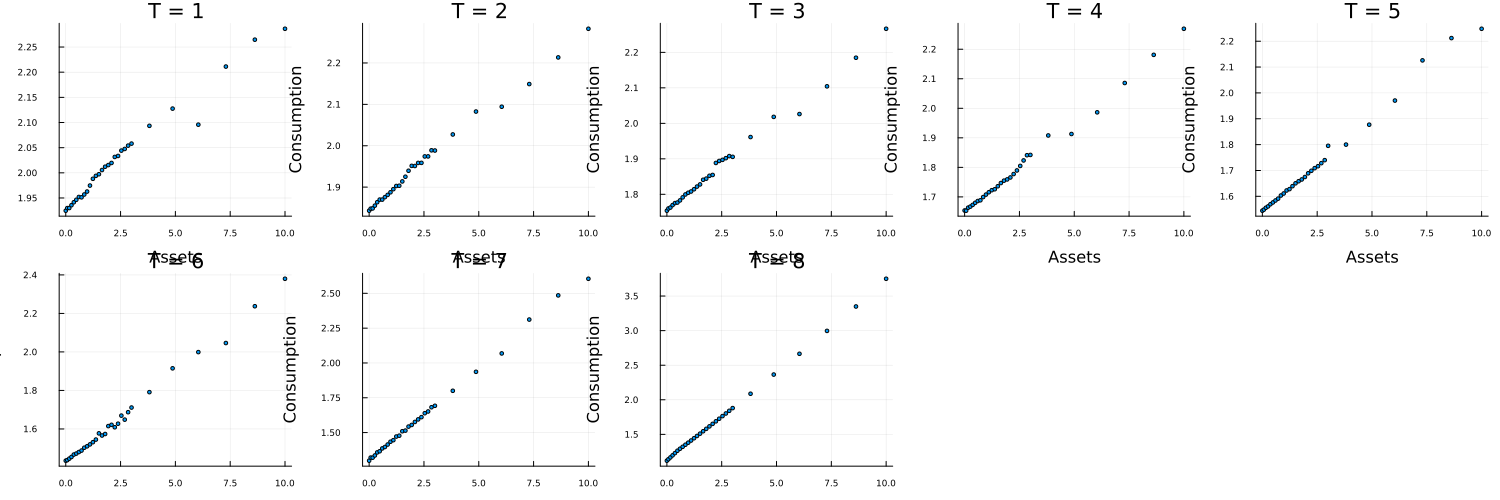

In [34]:
# visiualize the labor supply policy function for all the periods to see how it changes over time
gr()  # or your preferred backend

a_grid = model_baseline.a_grid
sol_h = model_baseline.sol_c
T = model_baseline.T
k_mid = Int(ceil(length(model_baseline.k_grid) / 2))  # pick a representative labor/skill state
hc_mid = Int(ceil(length(model_baseline.hc_grid) / 2))
plots = []

for t in 1:T
    p = scatter(a_grid, sol_h[t, :, k_mid, hc_mid],
        xlabel = "Assets",
        ylabel = "Consumption",
        title = "T = $t",
        label = false,
        markersize = 2,
        tickfontsize=6)
    push!(plots, p)
end

# Layout: adjust number of columns depending on how many you want per row
ncols = 5
plot(plots..., layout = (ceil(Int, T / ncols), ncols), size = (300 * ncols, 250 * ceil(Int, T / ncols)))